In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from grangercausality_test import GrangerCausalityTest
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.tsatools import lagmat2ds
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy import stats
from utils.utils import *
from statsmodels.tsa.vector_ar.var_model import VAR
path = '../stats_files/'

In [ ]:
tb = os.listdir('../stats_files')
tb

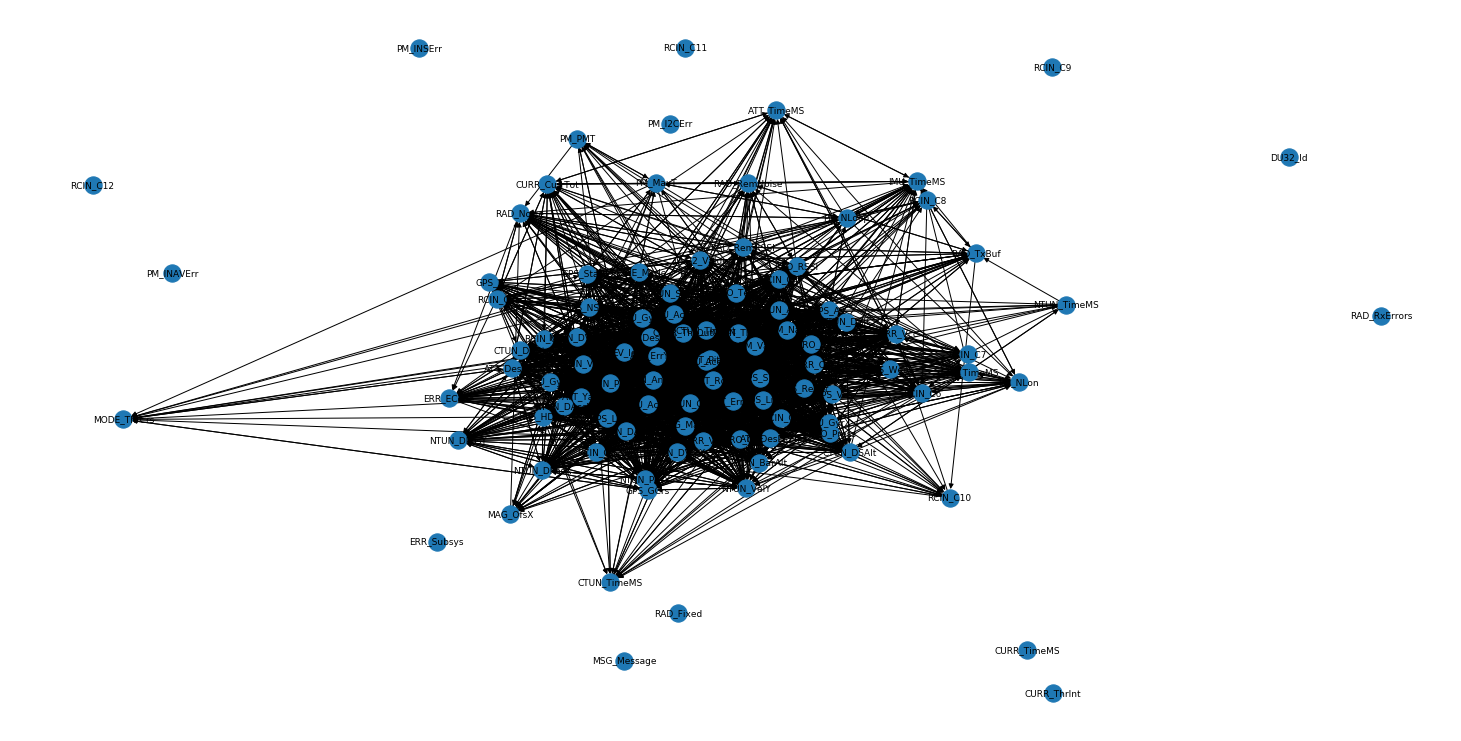

In [23]:
dg = load_pickle('../stats_files','directed_networkx_graph.pickle')
pos = nx.spring_layout(dg,k=0.3,iterations=10)
plt.figure(figsize=(20,10))
nx.draw(dg,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [20]:
nds = []
for n in dg.nodes:
    if 'Alt' in n:
        nds.append(n)
print(nds)

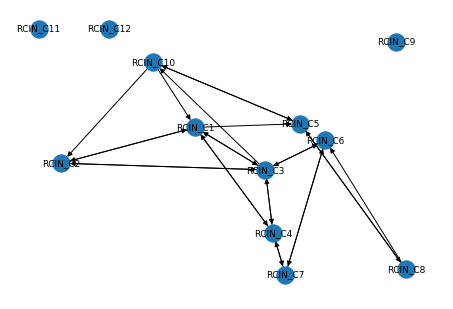

In [18]:
H = dg.subgraph(nds)
nx.draw(H,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [ ]:
df = pd.read_csv('../stats_files/full_causality_table.csv')
df.set_index(df.columns[0],inplace=True)

In [ ]:
DG = nx.DiGraph()
DG.add_nodes_from(df.columns)
for idx in df.index:
    ltuples = [(idx,cl) for cl in df.columns[df.loc[idx] == 1] if cl != idx]
    ltuples_bi = [(idx,cl) for cl in df.columns[df.loc[idx] == 2 ] if cl != idx] + [(cl,idx) for cl in df.columns[df.loc[idx] == 2 ] if cl != idx]
    DG.add_edges_from(ltuples)
    DG.add_edges_from(ltuples_bi)

save_as_pickle(DG,'../stats_files','directed_networkx_graph.pickle') #saving the graph to be used later for analysis
#create tuples
pos = nx.spring_layout(DG,k=1,iterations=50)
plt.figure(figsize=(20,10))
nx.draw(DG,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [ ]:
stat_in_out = []
for c in df.columns:
    outgoing_count = len(DG.out_edges(c))
    incoming_count = len(DG.in_edges(c))
    stat_in_out.append((c,incoming_count,outgoing_count))
df_inout = pd.DataFrame(stat_in_out,columns=['signal','incoming','outgoing'])

In [ ]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='incoming',data=df_inout.sort_values('incoming',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('incoming',ascending=False).signal,rotation=90)
plt.ylabel('Incoming Causes') 
plt.show()
figure = g.get_figure()  
figure.savefig('../report/incoming_causation.png', dpi=500)

In [ ]:
plt.figure(figsize=(20,15))
g = sns.barplot(x='signal',y='outgoing',data=df_inout.sort_values('outgoing',ascending=False))
g.set_xticklabels(labels=df_inout.sort_values('outgoing',ascending=False).signal,rotation=90)
plt.ylabel('Outgoing Causes')
plt.show()
figure = g.get_figure()  
figure.savefig('../report/outgoing_causation.png', dpi=500)

In [ ]:
df_inout.to_csv('../stats_files/causation_in_out_data.csv')

# Time Analysis

In [ ]:
tm = pd.read_csv(path+'causality_time_statistics.csv')
tm = tm.sort_values('size MB',ascending=True).reset_index().drop(tm.columns[:2],axis=1)

In [ ]:
tm.loc[len(tm)] = ('58c3e69a03d9b00f21696b11.log', 50.516817, 1349.1730382442474)

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(y='duration s',x='size MB',data=tm)
plt.ylabel('Seconds')
plt.xlabel('MB')
plt.title('Top 100 Causality Time Statistic')
plt.show()